<a href="https://colab.research.google.com/github/AlecTraas/computational-geo-lab/blob/main/Colab/Kai/hyperbolic_convex_hull.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Silence all warnings
warnings.filterwarnings("ignore")

In [2]:
def poincare_geodesic_origin(a_comp, b_comp):
    a, b = np.array([a_comp.real, a_comp.imag]), np.array([b_comp.real, b_comp.imag])

    c = b / np.sum(b**2)

    ab_mpt = (a + b) / 2
    ab_pbs = (b[0]-a[0])/(a[1]-b[1])
    ac_mpt = (a + c) / 2
    ac_pbs = (c[0]-a[0])/(a[1]-c[1])

    # just set the two perpendicular equal to one another and solve for x
    o_x = (-ab_pbs*ab_mpt[0]+ab_mpt[1]-ac_mpt[1]+ac_pbs*ac_mpt[0])/(ac_pbs-ab_pbs)
    o_y = ab_pbs*(o_x-ab_mpt[0])+ab_mpt[1]

    return (o_x,o_y)

In [3]:
def plot_pdsc_geodesic(a, b, c, ax):
    o = np.array(poincare_geodesic_origin(a,b))
    a = np.array([a.real,a.imag])
    b = np.array([b.real,b.imag])

    r = np.linalg.norm(o - a)

    a1 = np.arctan2(a[1] - o[1], a[0] - o[0])
    a2 = np.arctan2(b[1] - o[1], b[0] - o[0])

    if a2 < a1:
        a2 += 2 * np.pi
    if a1 - a2 > np.pi:
        a2 += 2 * np.pi
    elif a2 - a1 > np.pi:
        a2 -= 2 * np.pi

    theta = np.linspace(a1, a2, 1000)

    x_arc = o[0] + r * np.cos(theta)
    y_arc = o[1] + r * np.sin(theta)

    ax.plot(x_arc, y_arc, color=c)

In [4]:
# plots a geodesic segment through complex numbers a and b, with color c
def plot_uhp_geodesic(a,b,c):
    if abs(a.real - b.real) <= 2/900:
      plt.plot([a.real,b.real],[a.imag,b.imag],color=c)
      return
    o = ((a.real**2 + a.imag**2 - b.real**2 - b.imag**2) / (2*(a.real - b.real)), 0)
    x = np.linspace(min(a.real,b.real), max(a.real,b.real), 1000)
    arc = lambda x: np.sqrt(np.linalg.norm(np.array([a.real,a.imag]) - np.array(o))**2 - (x - o[0])**2) + o[1]
    y = [arc(xi) for xi in x]
    plt.plot(x,y,color=c)

In [5]:
# plots a list of points p, with color c
def plot_point(p,c):
    plt.scatter(np.real(p), np.imag(p), s=30, c=c, alpha=1)

In [6]:
# returns the distance between two points a and b
def dist(a,b):
  numer = np.abs(a - np.conjugate(b)) + np.abs(a - b)
  denom = np.abs(a - np.conjugate(b)) - np.abs(a - b)
  return np.log(numer/denom)

In [7]:
# returns the angle ∠ACB given points a, b, c
def angle(pa,pb,pc):
  a = dist(pb,pc)
  b = dist(pa,pc)
  c = dist(pa,pb)
  numer = np.cosh(a) * np.cosh(b) - np.cosh(c)
  denom = np.sinh(a) * np.sinh(b)
  return np.arccos(numer/denom)

In [8]:
# applies the Cayley transform to a set of points z in the upper half plane
def cayley(z):
  return (z-1j)/(z+1j)

In [19]:
def is_colinear(p):
  arr = np.array(p)
  return np.all(arr.imag == arr.imag[0]) or np.all(arr.real == arr.real[0])

In [20]:
def compute_hull(points):
  if is_colinear(points):
    return points
  hull_pts = []
  hull_pts.append(points[0])

  # this could break, but it is soooo unlikely.
  next_pt = hull_pts[0] - min(1,hull_pts[0].imag - 0.0001)*1j

  # initial hull point: I know, it's messy to have basically the same code as below outside the while loop, but I'm not clever enough to fit the starting point's case into the regular loop
  max_a = 0
  max_i = -1
  for k,p in enumerate(points):
    a = angle(next_pt,p,hull_pts[0])
    if a > max_a:
      max_i = k
      max_a = a
  next_pt = points[max_i]

  i = 0
  while next_pt not in hull_pts:
    max_a = 0
    max_i = -1
    for j,p in enumerate(points):
      a = angle(hull_pts[i],p,next_pt)
      if a > max_a:
        max_i = j
        max_a = a
    i += 1
    hull_pts.append(next_pt)
    next_pt = points[max_i]

  return hull_pts

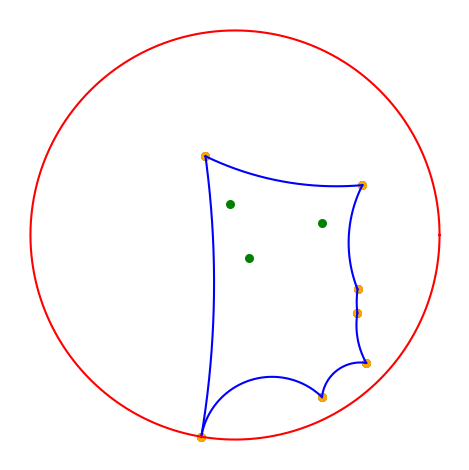

In [33]:
num = 10
span = 3
points = np.random.uniform(-span, span, num) + np.random.uniform(0, span, num) * 1j
points = sorted(points, key=lambda z: z.real)

hull_pts = compute_hull(points)

fig, ax = plt.subplots()

### plot upper half plane points ------
# ax.axhline(0, color='black')

# plot_point(points,'b')
# plot_point(hull_pts,'orange')

# for i in range(0,len(hull_pts)-1):
#   plot_uhp_geodesic(hull_pts[i],hull_pts[i+1],'green')
# plot_uhp_geodesic(hull_pts[0],hull_pts[len(hull_pts)-1],'green')
### -----------------------------------

### plot poincare disc points ---------
for p in points:
  plot_point(cayley(p),'g')
for p in hull_pts:
  plot_point(cayley(p),'orange')

for i in range(0,len(hull_pts)-1):
  plot_pdsc_geodesic(cayley(hull_pts[i]),cayley(hull_pts[i+1]),'b',ax)
plot_pdsc_geodesic(cayley(hull_pts[0]),cayley(hull_pts[len(hull_pts)-1]),'b',ax)

theta = np.linspace(0, 2*np.pi, 1000)
x = np.cos(theta)
y = np.sin(theta)
plt.plot(x, y, color = 'r')
### -----------------------------------

# formatting
ax.axis('off')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()